# IMPORTS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
data=pd.read_csv('wmap.csv')
data['x']

0        2
1        3
2        4
3        5
4        6
      ... 
894    896
895    897
896    898
897    899
898    900
Name: x, Length: 899, dtype: int64

In [85]:
data2=data[0:400]

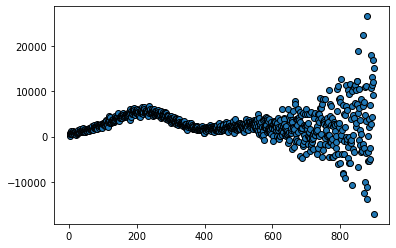

In [86]:
plt.figsize=(20,25)
plots=plt.scatter(data.x,data.y,edgecolors='black')
plt.show(plots)

# Functions

In [170]:
def power_func(x,d,q):
    G=[]
    x=np.array(x)
    j=1
    for i in range(0,(d+1+q)):
        if i<(d+1):
            G.append(x**i)
        else:
            sottr=900//(q+1)*j
            G.append((np.maximum(0,x-sottr))**d)
            j+=1
            
    return G

In [171]:
G_prova=power_func(data['x'],3,10)
G_prova

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

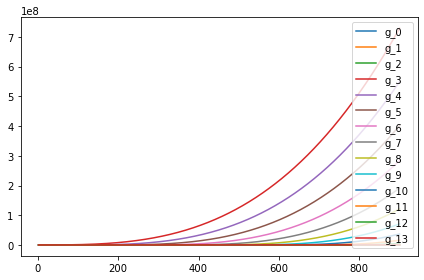

In [185]:
#Plot the loss function
fig=plt.plot(figsize=(25,20))

for i in range(0,14):
    plt.plot(data['x'],G_prova[i])#,label =("g_{}").format(i))

plt.legend()
plt.tight_layout()
plt.show()



In [90]:
def pre_processing(x,d,q):
    mat=power_func(x,d,q)
    mat=np.array(mat)
    return np.transpose(mat)

In [91]:
def CV_score (d,q,x=data.x,y=data.y):
    X = pre_processing(x,d,q)
    plm = LinearRegression(fit_intercept=False).fit(X,data.y)
    Y_hat = plm.predict(X)
    MSE_tr = mean_squared_error(y,Y_hat)
    GCV_score=MSE_tr/((1-((d+1)/len(x)))**2)
    return GCV_score

In [92]:
def main(d,q,x=data.x,y=data.y):
    scores=CV_score(d,q,x=data.x,y=data.y)
    return round(scores,2)

# GCV d=3

9 9424840.99


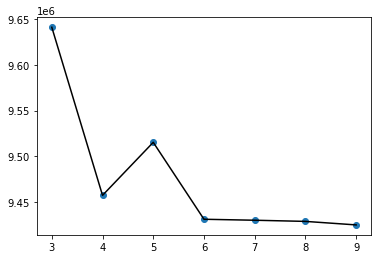

In [93]:
# for d=3 
knots=list(range(3,10))
# print(knots)
res=list(map(main,[3]*len(knots),knots,data.x,data.y))
ind=np.argmin(res)
print(knots[ind],res[ind])
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.show()

# GCV d=1

9 9383559.66


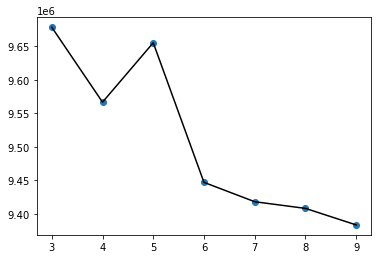

In [94]:
# for d=1 
knots=list(range(3,10))
# print(knots)
res=list(map(main,[1]*len(knots),knots,data.x,data.y))
ind=np.argmin(res)
print(knots[ind],res[ind])
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.show()

# Stratified CV

In [40]:
def assign_folds(k,d=data):
    if k<=1:
        raise TypeError("Only integers >1 are allowed") 
    #k=n_folds>1
    folds=[]
    
    #Assign classes
    d.loc[0:399,'class']=0
    d.loc[400:900,'class']=1
    d=d.astype({'class':int})
    
    #Assign a column to determine whether a row has already been used or not
    d.loc[0:900,'picked'] = 0

    #Create folds
    for i in range(k):
        sample=d[d['picked']==0].groupby('class', group_keys=False).apply(lambda x: x.sample(frac=1/(k-i))) 
        #set to 1 the picked rows
        d.loc[sample.index,'picked']=1
        #save the single fold
        folds.append(sample)   
        
    return (folds)

In [36]:
prova=data
f=assign_folds(k=12,d=prova)

In [37]:
for i in range(len(f)):
    print(len(f[i]))

75
75
75
74
76
74
76
74
76
74
76
74


In [39]:
(f[2]['class']==0).sum()

33

# porcherie

In [ ]:
res

In [ ]:
data2=data[400:]

In [ ]:
X=pre_processing(data.x,1,23)
print(X)


In [ ]:
plm=LinearRegression(fit_intercept=False).fit(X,data.y)
c=plm.coef_
c

In [ ]:
plm = LinearRegression(fit_intercept=False).fit(X,data.y)
Y_hat_ = plm.predict(X)
MSE_tr_ = mean_squared_error(data.y,Y_hat_)
GCV_score_ = MSE_tr_/((1-((3+1)/len(data.x)))**2)
print(MSE_tr_)

In [ ]:
plt.scatter(data.x,data.y,edgecolors='black')
plt.plot(data.x,np.sum((X*c),axis=1),color='red')
plt.show()
# evidenzia i knots

# polyfit

In [ ]:
# polynomial test
poly=np.polyfit(data.x,data.y,1)
y_hat=np.polyval(poly,data.x)
mse=mean_squared_error(data.y,y_hat)
mse/((1-4/len(data.x))**2)